# Diagnostics - xrft + Isotropic Wavenumber

In this notebook, we are going to look at some simulations that we have available and analyze some of the statistical properties of the datasets. 

In [28]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [29]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal
from alti_tools._src.viz import psd as psd_plots

import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

try:
    import powerspec as ps
except ModuleNotFoundError:
    !pip install powerspec
    import powerspec as ps  

import xarray as xr
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NATL60 Data

### Sea Surface Height

* [Source](https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/catalog/meomopendap/extract/ocean-data-challenges/dc_data1/dc_ref/catalog.html)

In [30]:
download_ssh_toy("natl60")

In [31]:
# # get directoru
# data_path = Path("/Users/eman/.CMVolumes/cal1_workdir/data/dc_2020/dc_ref")

# # list all files in directory
# data_names = list(data_path.glob("*.nc"))

# # sample name
# data_name = data_path.joinpath("NATL60-CJM165_GULFSTREAM_y2012*.nc")

In [32]:
# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("NATL60-CJM165_GULFSTREAM_y2013m09d30.1h_SSH.nc")
ds_grid

<xarray.Dataset>
Dimensions:   (time: 24, lat: 600, lon: 600)
Coordinates:
  * lon       (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time      (time) datetime64[ns] 2013-09-30T00:30:00 ... 2013-09-30T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 ...
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

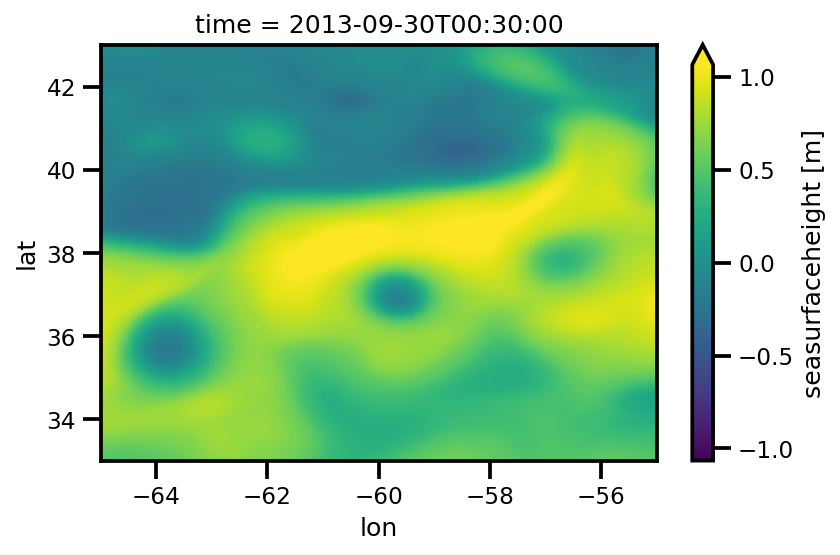

In [33]:
fig, ax = plt.subplots()

ds_grid.isel(time=0).sossheig.plot(ax=ax, cmap="viridis", robust=True)

plt.tight_layout()
plt.show()

In [34]:
ds_grid["u"] = ds_grid["sossheig"].differentiate(coord="lon")
ds_grid["v"] = ds_grid["sossheig"].differentiate(coord="lat")
ds_grid["ke"] = 0.5 * (ds_grid["u"]**2 + ds_grid["v"]**2)

ds_grid["du2"] = ds_grid["u"].differentiate(coord="lon").differentiate(coord="lon")
ds_grid["dv2"] = ds_grid["v"].differentiate(coord="lat").differentiate(coord="lat")
ds_grid["lap"] = 0.5 * (ds_grid["du2"]**2 + ds_grid["dv2"]**2)

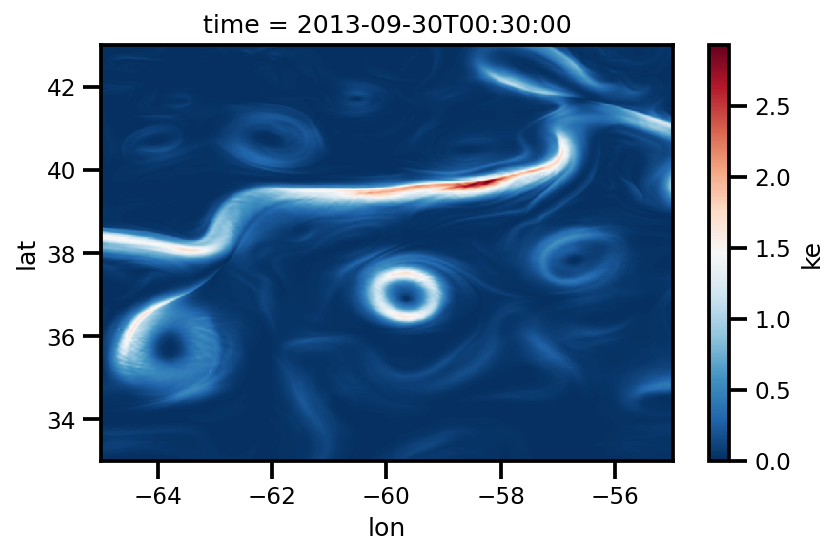

In [35]:
fig, ax = plt.subplots()

ds_grid["ke"].isel(time=0).plot(ax=ax, cmap="RdBu_r", robust=None, vmin=0.0)

plt.tight_layout()
plt.show()

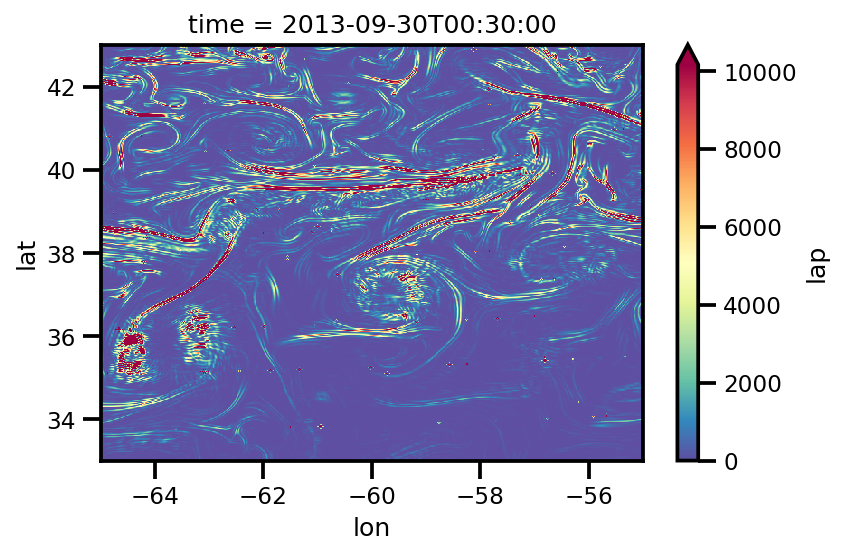

In [36]:
fig, ax = plt.subplots()

ds_grid["lap"].isel(time=0).plot(ax=ax, cmap="Spectral_r", robust=True, vmin=0.0)

plt.tight_layout()
plt.show()

In [37]:
# open dataset
ds_grid = xr.open_dataset("NATL60-CJM165_GULFSTREAM_y2013m09d30.1h_SSH.nc")

ds_ssh = ds_grid.sossheig

# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))

In [38]:
def isotropic_power_spectrum(ds, **kwargs):

    # compute power spectrum (window=True
    signal_psd = xrft.isotropic_power_spectrum(
        ds, dim=['lat','lon'], 
        detrend='linear', window="tukey", 
        nfactor=2,
        window_correction=True, true_amplitude=True, truncate=True
    )

    # calculate mean signal
    signal_psd_mean = signal_psd.mean(dim=['time'], skipna=True)

    # convert from km to m
    signal_psd_mean *= 1e3
    
    return signal_psd_mean

def isotropic_power_spectrum_dask(ds):
    
    with ProgressBar():
        signal = ds.chunk({"time":1, 'lon': ds['lon'].size, 'lat': ds['lat'].size})
        
        signal_psd_mean = isotropic_power_spectrum(signal)
        
    return signal_psd_mean
    

In [39]:
ds_psd = isotropic_power_spectrum(ds_ssh)
ds_psd = isotropic_power_spectrum_dask(ds_ssh)

[########################################] | 100% Completed |  0.9s


In [40]:
ds_psd.attrs["label"] = "Sea Surface Height"

#### Wavenumber

$$
\mathbf{\lambda}, k_r
$$

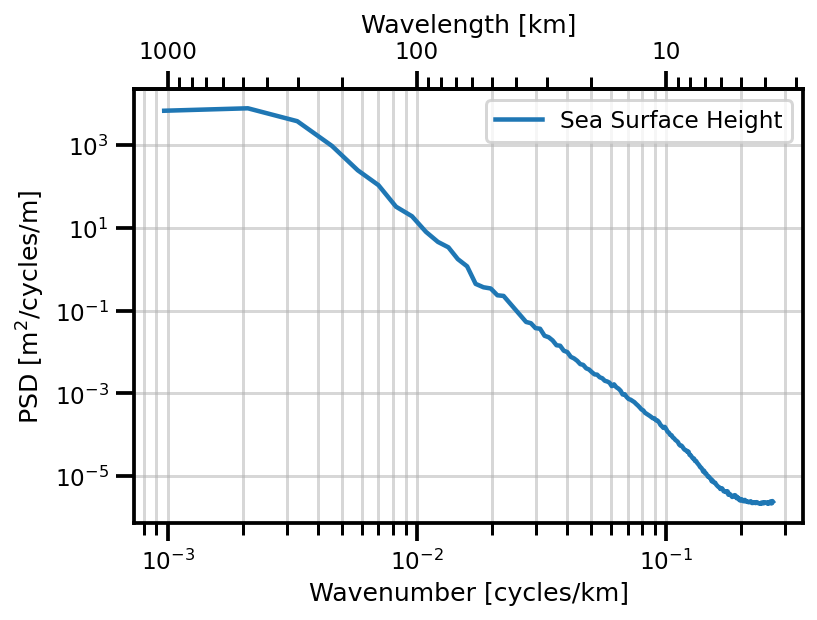

In [41]:
fig, ax = psd_plots.plot_psd_wavenumber(ds_psd)

#### Wavelength

$$
\frac{1}{k_r}
$$

Mostly for visualization purposes. This is much easier to read the actual wavelength of the respective distances.

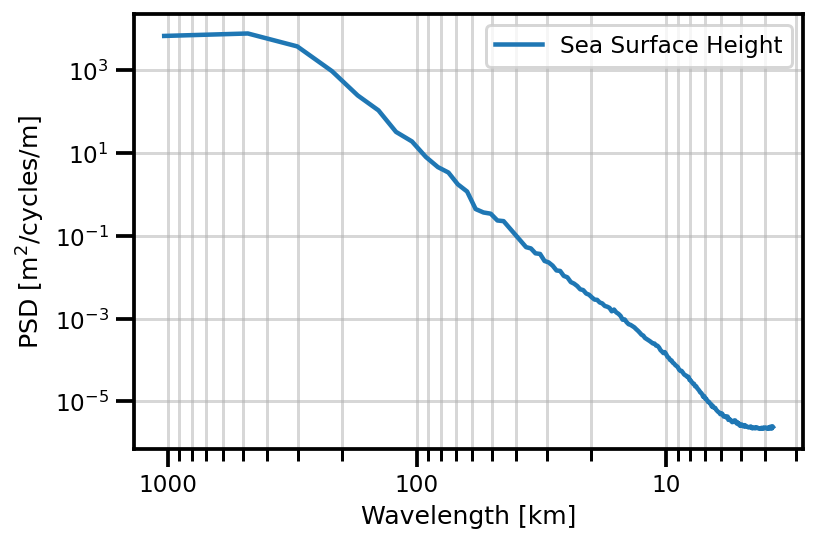

In [42]:
fig, ax = psd_plots.plot_psd_wavelength(ds_psd)

#### Wavenumber & Wavelength

**Source**: 
* https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html
* https://matplotlib.org/stable/gallery/ticks/tick-formatters.html

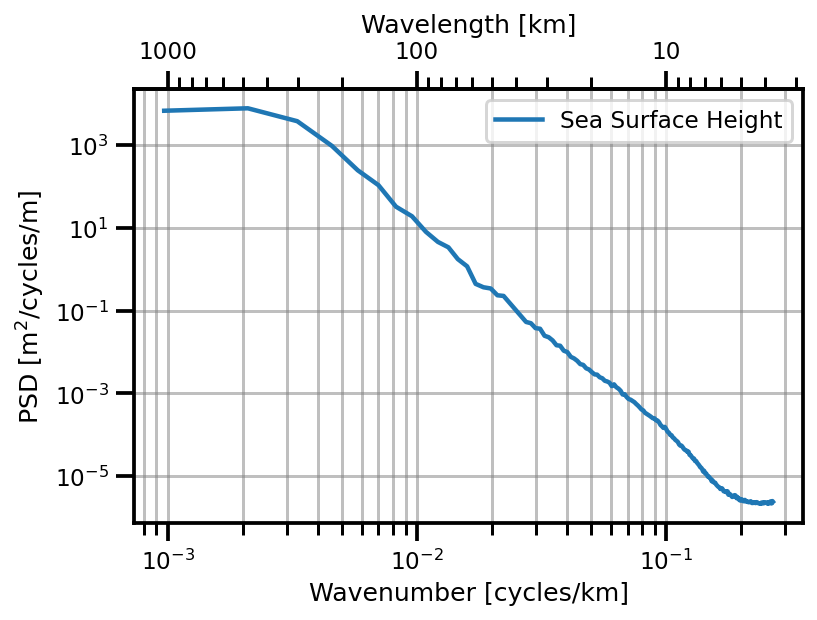

In [43]:
fig, ax = psd_plots.plot_psd(ds_psd)

## Reconstruction Datasets

In [44]:
download_ssh_toy("4dvarnet")
# download_ssh_toy("duacs")
download_ssh_toy("miost")

In [45]:
# NATL60
ds_grid = xr.open_dataset("NATL60-CJM165_GULFSTREAM_y2013m09d30.1h_SSH.nc")


ds_ssh = ds_grid.sossheig

# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))

ds_psd_natl60 = isotropic_power_spectrum_dask(ds_ssh)

ds_psd_natl60.attrs["label"] = "NATL60"

[########################################] | 100% Completed |  1.4s


In [46]:

# 4DVARNET Reconstruction
ds_grid = xr.open_dataset("2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc")

ds_ssh = ds_grid.ssh
# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))


ds_psd_4dvar = isotropic_power_spectrum_dask(ds_ssh)

[########################################] | 100% Completed |  0.7s


**TODO**: Fix NANS!

In [47]:

# ds_grid = xr.open_mfdataset(data_names[:1], engine="netcdf4")
ds_grid = xr.open_dataset("2020a_SSH_mapping_NATL60_MIOST_swot_en_j1_tpn_g2.nc")

ds_ssh = ds_grid.gssh

ds_ssh = ds_ssh.interpolate_na(dim="lat", method="linear", fill_value="extrapolate")
ds_ssh = ds_ssh.interpolate_na(dim="lon", method="linear", fill_value="extrapolate")
# convert lat/lon, degrees -> meters
ds_ssh = spatial.coords_degree_2_meters(ds_ssh)

# convert time stamps -> days
ds_ssh = temporal.coords_temporal_normalize(ds_ssh, np.timedelta64(1, "D"))


ds_psd_miost = isotropic_power_spectrum(ds_ssh)

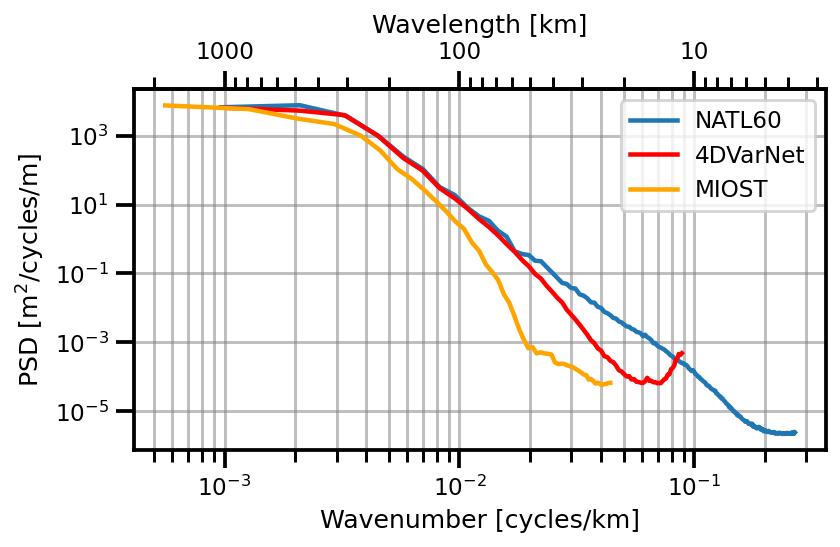

In [48]:
fig, ax = psd_plots.plot_psd(ds_psd_natl60)

ax.plot( 
    ds_psd_4dvar.freq_r,
    ds_psd_4dvar,
    label="4DVarNet", color="red"
)

ax.plot( 
    ds_psd_miost.freq_r,
    ds_psd_miost,
    label="MIOST", color="orange"
)

ax.legend()
ax.grid(which="both", alpha=0.5)

plt.tight_layout()
plt.show()